The primary objective of this exercise will be to condense the kitchen-sink model we used last time and create a minimal set of features that performs as well (or maybe even better) than a complex feature set.

In [2]:
#to bring print function from later versions of python into this one
from __future__ import print_function
import math
from IPython import display

#for data visualization & interaction
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

#support for higher dimensional objects in data manipulation
import numpy as np
import pandas as pd
from sklearn import metrics


import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

#so we are not flooded with output anytime we print out the results
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

#DONT FORGET TO RANDOMIZE THE DATA!
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))


Just like last time, make some use of functional programming to extract our feature and target sets respectively. 

In [2]:
"""Pre-processes input features from California Housing Dataset
    Args:
        california_housing_dataframe: A pandas dataframe with
        data from the California Housing Dataset
    Returns:
        A dataframe containing the features to be used for the model
        including synthetic features

"""
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[[
        "latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income"
    ]]
    #shallow copy to save space (contains references to original)
    processed_features = selected_features.copy()
    
    #Only creating one processed feature in this example
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"]/
        california_housing_dataframe["population"])
    
    return processed_features



""" Prepare target features or labels
    Args:
        california_housing_dataframe: A pandas dataframe with
        data from the California Housing Dataset
    Returns:
        A pandas dataframe containing target features

"""
def preprocess_targets(california_housing_dataframe):
    
    output_targets = pd.DataFrame()
    #scale target
    output_targets["median_house_value"] = (california_housing_dataframe["median_house_value"]/1000)
    
    return output_targets
    

Next we partition our data into the training and validation examples and targets and check whether we did this correctly. 

In [3]:
# Choose the first 12000  examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000  examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))


print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2642.9,540.5,1425.1,501.8,3.9,2.0
std,2.1,2.0,12.6,2187.6,423.3,1124.3,385.7,1.9,1.1
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1465.0,296.0,787.0,281.8,2.6,1.5
50%,34.2,-118.5,29.0,2129.5,435.0,1165.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3145.2,652.0,1721.0,607.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,41.3


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2645.5,536.8,1440.3,499.9,3.9,2.0
std,2.1,2.0,12.7,2161.6,417.1,1202.6,381.8,2.0,1.4
min,32.5,-124.3,1.0,15.0,4.0,9.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1453.0,297.0,793.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2123.5,431.0,1170.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3166.2,640.0,1720.0,598.0,4.8,2.3
max,41.9,-114.6,52.0,30405.0,4819.0,35682.0,4769.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.4
std,115.4
min,15.0
25%,120.8
50%,180.8
75%,264.4
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,207.1
std,117.3
min,15.0
25%,117.0
50%,178.8
75%,266.5
max,500.0


First things first, lets see if we can develop a good feature set. One thing to consider when constructing a regression model is multicollinearity between our predictors or features. Typically, this can be measured using correlation or a more sophisticated technique such as Variance Inflation factors. 

**Why should we even care about multicollinearity though?**

To be honest, its not a really a big deal. It doesnt change the predictive power of our model (at least on the training data) but it DOES screw with coefficient estimates. Also, having independent features can help us add independent information to our model, more likely than not increasing the predictive power of our model OOS. Eventually, this can be rectified/characterized when we continue to do robust model validation (i.e. LOO/K-fold cross-validation). *Just a side note for those interested in why we like to look at correlation between variables.* 

On another note, there are also methods of shrinkage which can reduce our feature set using techniques such as LASSO or an elastic net (but thats beyond the scope of this analysis). 

Alright, I apologize for the digression, lets get back to the problem at hand. We can plot a pairwise pearson correlation matrix for the features and targets to get a better idea of what features will add information to our model. 

In [4]:
#Make a shallow copy of the training examples 
correlation_matrix = training_examples.copy()

#add the column target 
correlation_matrix["target"] = training_targets["median_house_value"]

correlation_matrix.corr()


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.2,-0.2
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.1,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.3,0.7
rooms_per_person,0.2,-0.1,-0.1,0.1,0.1,-0.1,-0.0,0.3,1.0,0.2
target,-0.2,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


Hmm..Median income seems to have a strong positive correlation to our target, the rest of the features dont seem to have a strong correlation. Total rooms also seem very highly correlated to bedrooms and population (which does make alot of intuitive sense). I'll be leaving out a discussion of longitude and latitude since they require special treatment due to the spatialistic nature of them (not sure if thats a word, but I'm going to use it anyway...sue me). 

Anyway, lets set up the boiler plate code for defining feature columns and input function to pass into TF and our train model function we've been using in our exercises. 

In [6]:
"""Construct TF feature columns

    Args:
        input_features: Names of input features to use
    Returns: 
        set of feature columns

"""
def construct_feature_columns(input_features):
    
    return set([tf.feature_column.numeric_column(my_feature)
               for my_feature in input_features])


In [7]:
"""Trains a linear regression model.
    Args: 
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Int size of batches to be passed to the model
        shuffle: Boolean of whether to shuffle the data
        epochs: Int Number of epochs for which data should be repeated.
            default value = None
    Returns:
        Tuple of (features, labels) for the next data batch
    
""" 
#This is the same function we used in our last exercise.
def my_input_fn(features, targets, batch_size = 1, shuffle=True, num_epochs = None):
    
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size = 10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels
    

Finally, we create our boilerplate train function below

In [11]:
"""This function trains a linear regression model of multiple features

    Args:
        learning_rate: A 'float', learning rate
        steps: A non-zero 'int', total training steps taken (each step is forward
            and backward pass using single batch)
        batch_size: A non-zero 'int', the batch size
        training_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for validation.
            
    Returns:
        A LinearRegressor object trained on training data
        Plots RMSE value at each training period step 
        Plots learned regression line at each training period

"""
def train_model(learning_rate, steps, batch_size, training_examples,
               training_targets, validation_examples, validation_targets):
    
    periods = 10
    steps_per_period = steps/periods
    
    #Define our Linear Regressor optimizer and create the object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = construct_feature_columns(training_examples),
        optimizer = my_optimizer)
    
    
    #create our input functions
    training_input_fn = lambda: my_input_fn(training_examples, 
                                            training_targets["median_house_value"], 
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                    training_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                      validation_targets["median_house_value"], 
                                                      num_epochs=1, 
                                                      shuffle=False)
    
    print("Training model..")
    print("RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    
    for period in range(0, periods):
        
        #train model starting from prior state
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period)
        
        #compute predictions
        training_predictions = linear_regressor.predict(input_fn = predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        #compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        
        #Print current loss
        print(" period %02d : %0.2f" % (period, training_root_mean_squared_error))
        
        #finally, append current loss metrics to list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print("Model Training is now finished")
    
    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor


Now that we finished setting that up, lets look at a minimal feature set we can create and pass to our model. From above, it does seem like median_income is a strong predictor, as is rooms per person and latitude but since latitude is negative correlated, I think it does make for a better feature to use. 

Training model..
RMSE (on training data): 
 period 00 : 218.88
 period 01 : 201.01
 period 02 : 183.93
 period 03 : 167.88
 period 04 : 154.57
 period 05 : 142.05
 period 06 : 132.79
 period 07 : 125.92
 period 08 : 122.91
 period 09 : 120.76
Model Training is now finished


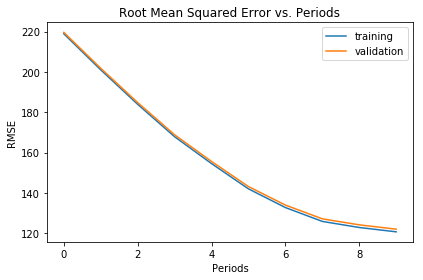

In [13]:
minimal_features = ["median_income", "latitude"]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

train_model(
    learning_rate = 0.003,
    steps = 500,
    batch_size = 5,
    training_examples = minimal_training_examples,
    training_targets = training_targets,
    validation_examples = minimal_validation_examples,
    validation_targets = validation_targets)

Now, lets take a closer look at latitude. 


Well look at that, way better now than our last kitchen sink model. But I suspect we can do even better if we take a closer look at latitude. Before someone yells at me, I know that we could do better if we tweak the parameters but the gist of the exercise was to delineate the idea that just because there are more features in a model doesnt mean that the model becomes a necessarily better one. 

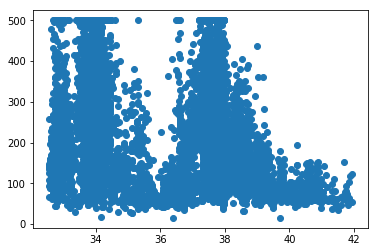

In [14]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

We see that there are two specific peaks corresponding to San Francisco and Los Angeles respectively. Theres a few ways to go about this, we could make another feature that essentially takes distance from each city but thats not very rigorous now is it? Lets do something a bit more nuanced and bucket the latitude ranges which we do below.

In [24]:
#We are creating a list of tuples to iterate through
Latitude_range = zip(range(32,44), range(33,45))

#Takes in a dataframe of examples and extracts features to be used. Returns those features in a dataframe
def select_features(examples):
    
    selected_examples = pd.DataFrame()
    selected_examples["median_income"] = examples["median_income"]
    
    #for r, a tuple representing the range of latitudes,
    for r in Latitude_range:
        selected_examples["latitude_%d_to_%d" % r] = examples["latitude"].apply(
            lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)

    return selected_examples

new_training_examples = select_features(training_examples)
new_validation_examples = select_features(validation_examples)

Training model..
RMSE (on training data): 
 period 00 : 206.96
 period 01 : 177.51
 period 02 : 149.49
 period 03 : 123.99
 period 04 : 104.66
 period 05 : 91.94
 period 06 : 86.01
 period 07 : 84.99
 period 08 : 84.60
 period 09 : 84.36
Model Training is now finished


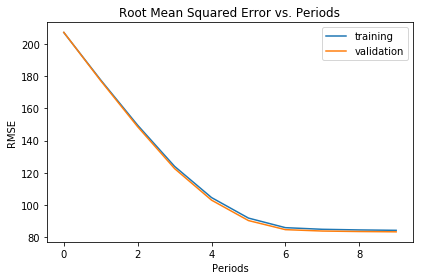

In [25]:
train_model(
    learning_rate = 0.03,
    steps = 500,
    batch_size = 5,
    training_examples = new_training_examples,
    training_targets = training_targets,
    validation_examples = new_validation_examples,
    validation_targets = validation_targets
    )

Well will ya look at that, we got to $\frac{2}{3}$ RMSE loss vs. our original model earlier in the notebook. Can we do better? *Probably*

But I'll leave it to the reader to look at ways to extend the model. Off the top of my head, one thing we could do is also bin the longitude and use those as predictors.  